# Gamma ray bursts

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [1]:
import requests
from sklearn import datasets
from sklearn import mixture
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib import colors
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import seaborn

%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(5, 5), dpi=120)
plt.rcParams.update({'font.size': 9})

Download date from the source: 

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
data  # check what 'data' variable contains

array([['GRB230421A*', 'GRB230420A', 'GRB230419A*', ..., 'GRB910424A*',
        'GRB910423A*', 'GRB910421A*'],
       ['GRB230421405', 'None', 'GRB230419568', ..., 'None', 'None',
        'None'],
       ['9:42:41.253', '10:19:01', '13:37:43.335', ..., '19:43:25.064',
        '19:51:15.804', '9:14:03.800'],
       ...,
       ['9.7280', '111.7500', '0.2560', ..., '3.1360', '208.5760',
        '5.6960'],
       ['True', 'False', 'True', ..., 'False', 'False', 'False'],
       ['60055.40464413', '60054.42987269', '60053.56786267', ...,
        '48370.82181787', '48369.82726625', '48367.38476620']],
      dtype='<U14')

Create the arrays of variable I want to analyze: 

In [4]:
T90_s = np.array(data[6],dtype=float)
z_s = np.array(data[11],dtype=float)
fluence_s = np.array(data[9],dtype=float)

In [5]:
z_corr = z_s[z_s>0]
fluence_corr = fluence_s[fluence_s>0]
T90_corr = T90_s[T90_s>0]

# 1-D distributions

I here report the 1-dimensional distribution of the three variables I decided to study. I will then apply some statistics to se if I can catch some of the features of these curves, and link them to the physics of gamma ray bursts (which I know little about, but will compensate with the help of Google). 

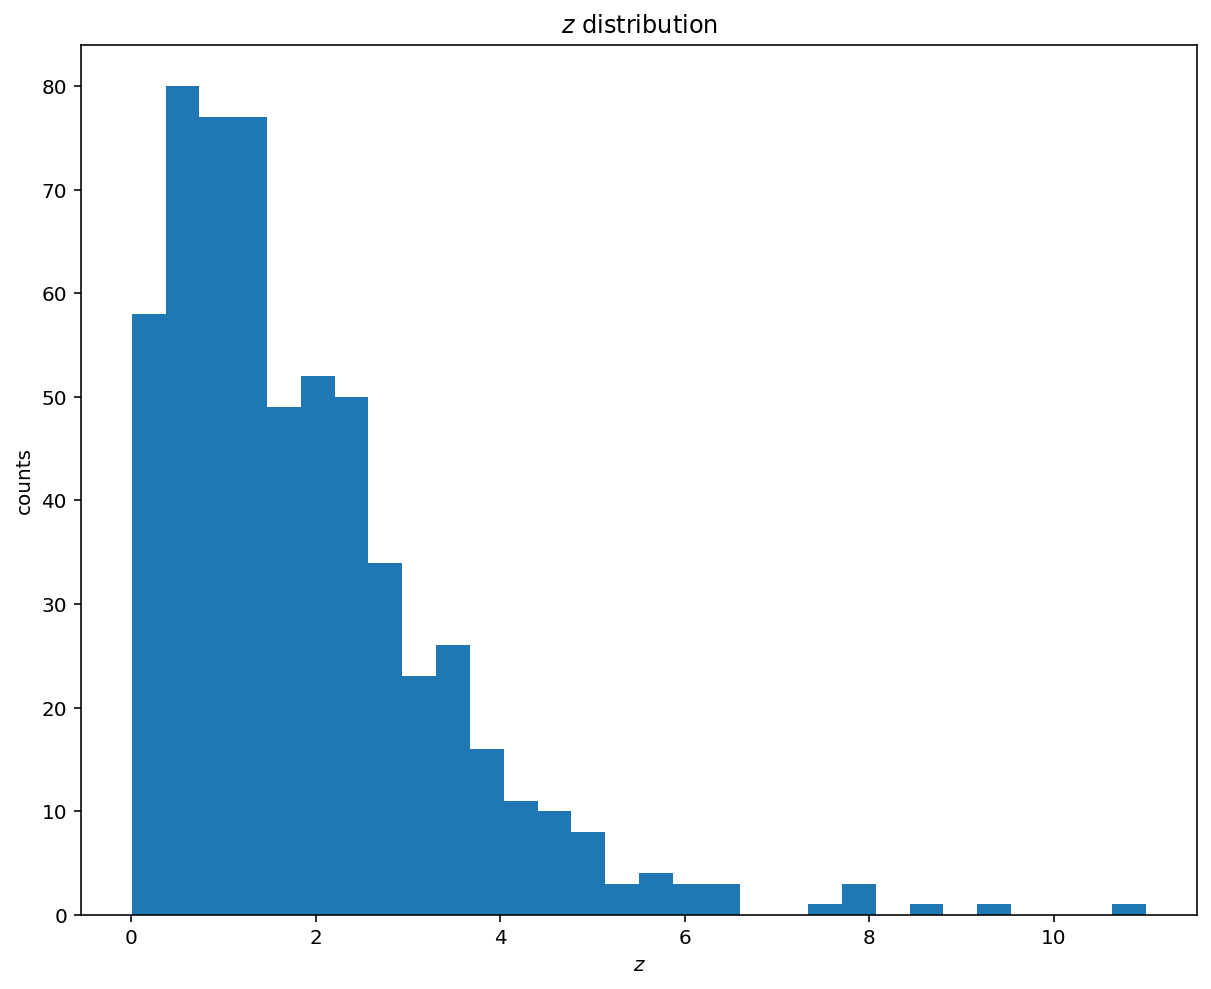

In [6]:
# Redshift

plt.figure(figsize=(10,8))
plt.hist(z_corr, bins=30)
plt.xlabel(r"$z$")
plt.ylabel(r'counts')
plt.title('$z$ distribution');

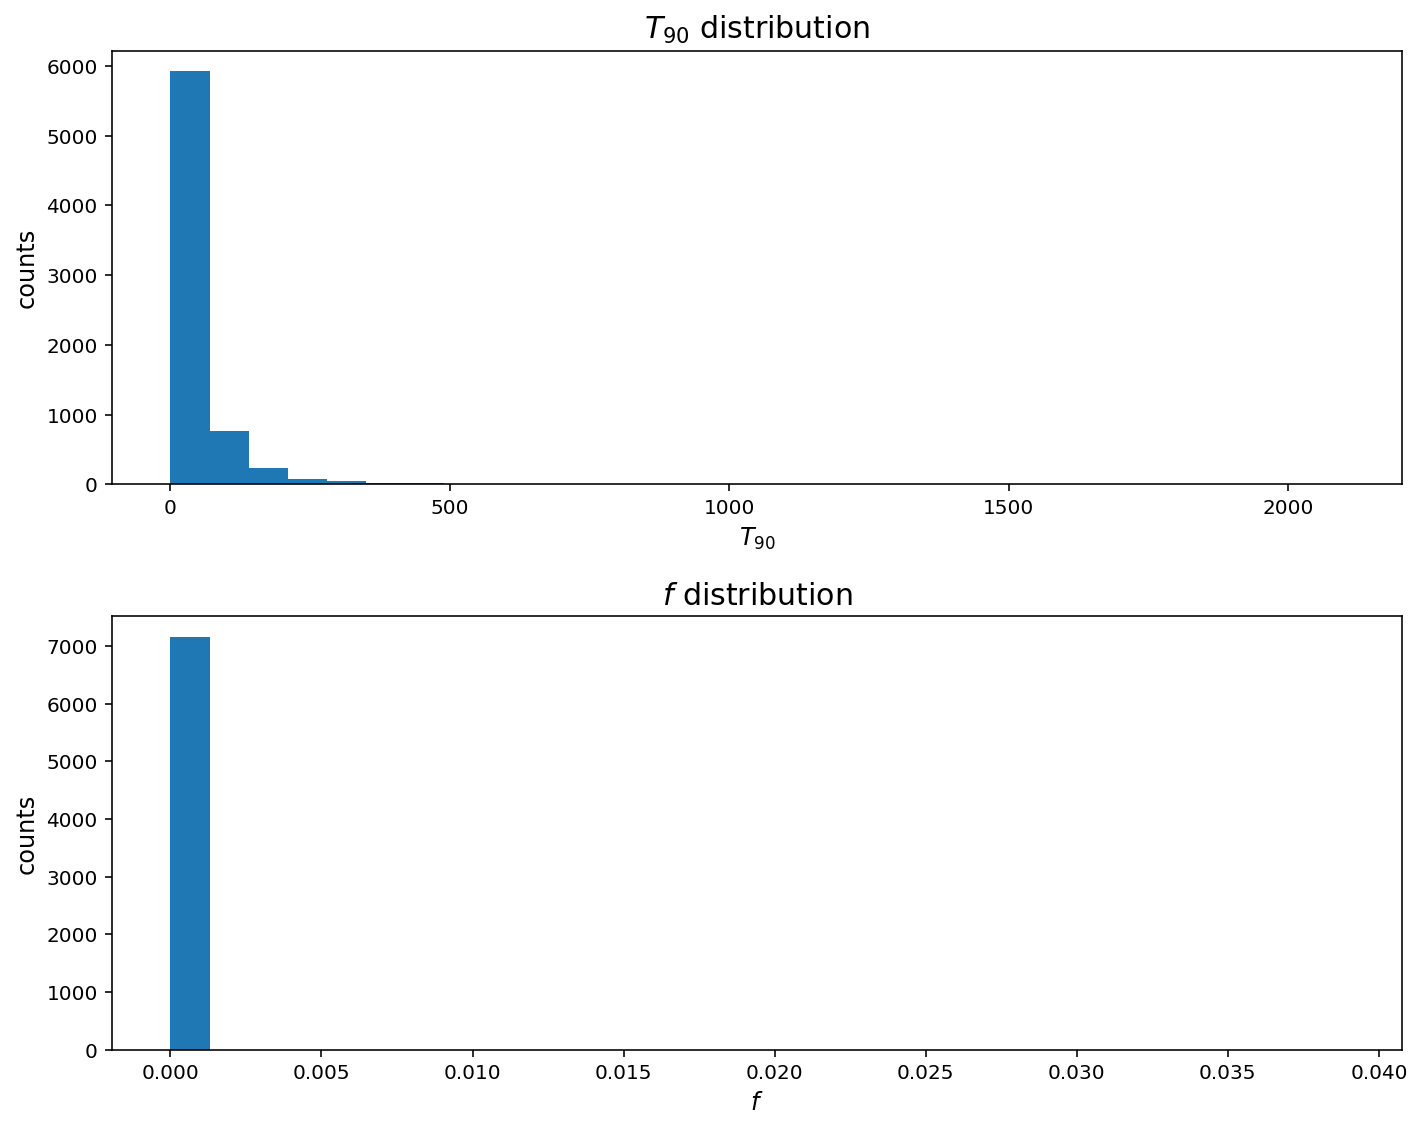

In [7]:
# T90 (duration) and fluence

fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].hist(T90_corr, bins=30)
ax[0].set_xlabel(r"$T_{90}$", fontsize=12)
ax[0].set_ylabel(r'counts', fontsize=12)
ax[0].set_title('$T_{90}$ distribution', fontsize=15)

ax[1].hist(fluence_corr, bins=30)
ax[1].set_xlabel(r"$f$", fontsize=12)
ax[1].set_ylabel(r'counts', fontsize=12)
ax[1].set_title('$f$ distribution', fontsize=15)

fig.tight_layout();

It is difficult to extrapolate something out of these plots. I will try to switch to log scale: 

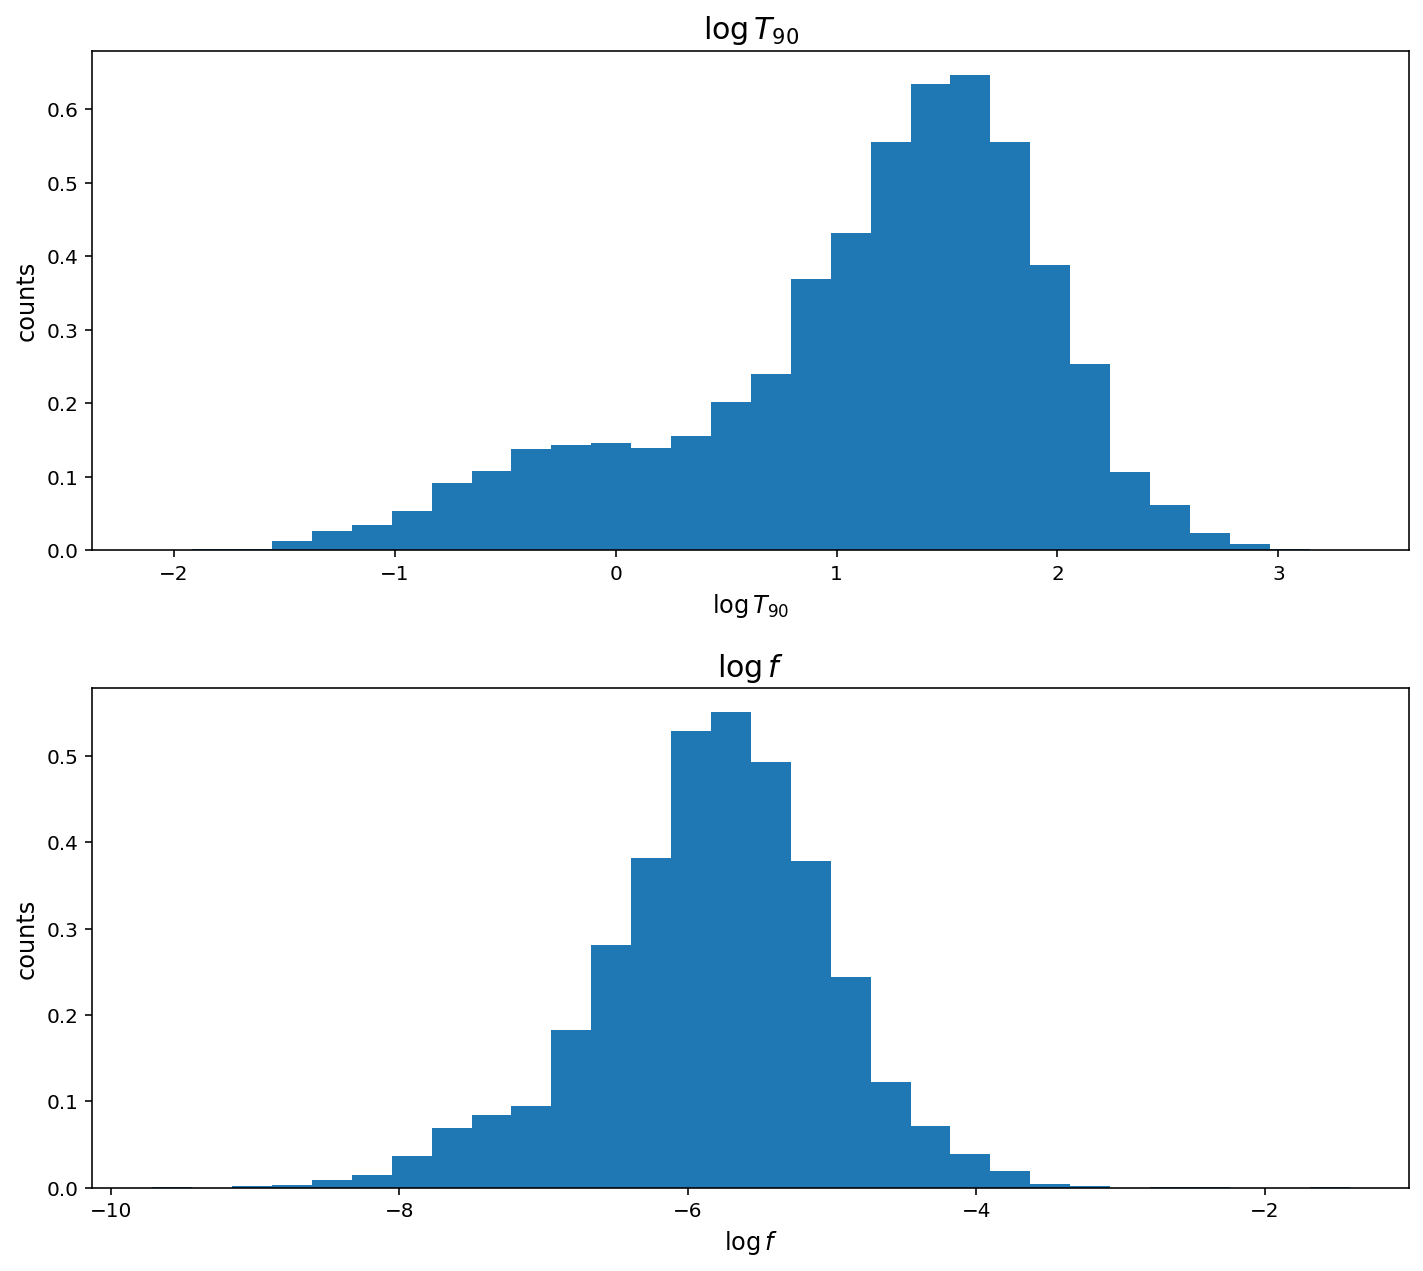

In [8]:
fig, ax = plt.subplots(2, figsize=(10,9))

ax[0].hist(np.log10(T90_corr), bins=30, density=True)
ax[0].set_xlabel(r"$\log{T_{90}}$", fontsize=12)
ax[0].set_ylabel(r'counts', fontsize=12)
ax[0].set_title(r"$\log{T_{90}}$", fontsize=15)

ax[1].hist(np.log10(fluence_corr), bins=30, density=True)
ax[1].set_xlabel(r"$\log{f}$", fontsize=12)
ax[1].set_ylabel(r'counts', fontsize=12)
ax[1].set_title(r"$\log{f}$", fontsize=15)

fig.tight_layout();

Much better!

## KDE 

I now carry out the kernel density estimation we saw some lectures ago. 
We represent each data point not as a delta function, but rather as a distribution. Those individual distributions are summed up to produce the PDF.  

In [9]:
def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

### $z$

In [10]:
bwrange = np.linspace(0.01, 0.5, 20) # Test 10 bandwidths from 0.1 to 1.0
print(bwrange)

K = 5 # Do 5-fold cross validation

X_z = z_corr[:, None]

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(X_z) #Fit the histogram data 

h_opt = (grid.best_params_['bandwidth'])
    
print(h_opt)

[0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
0.3968421052631579


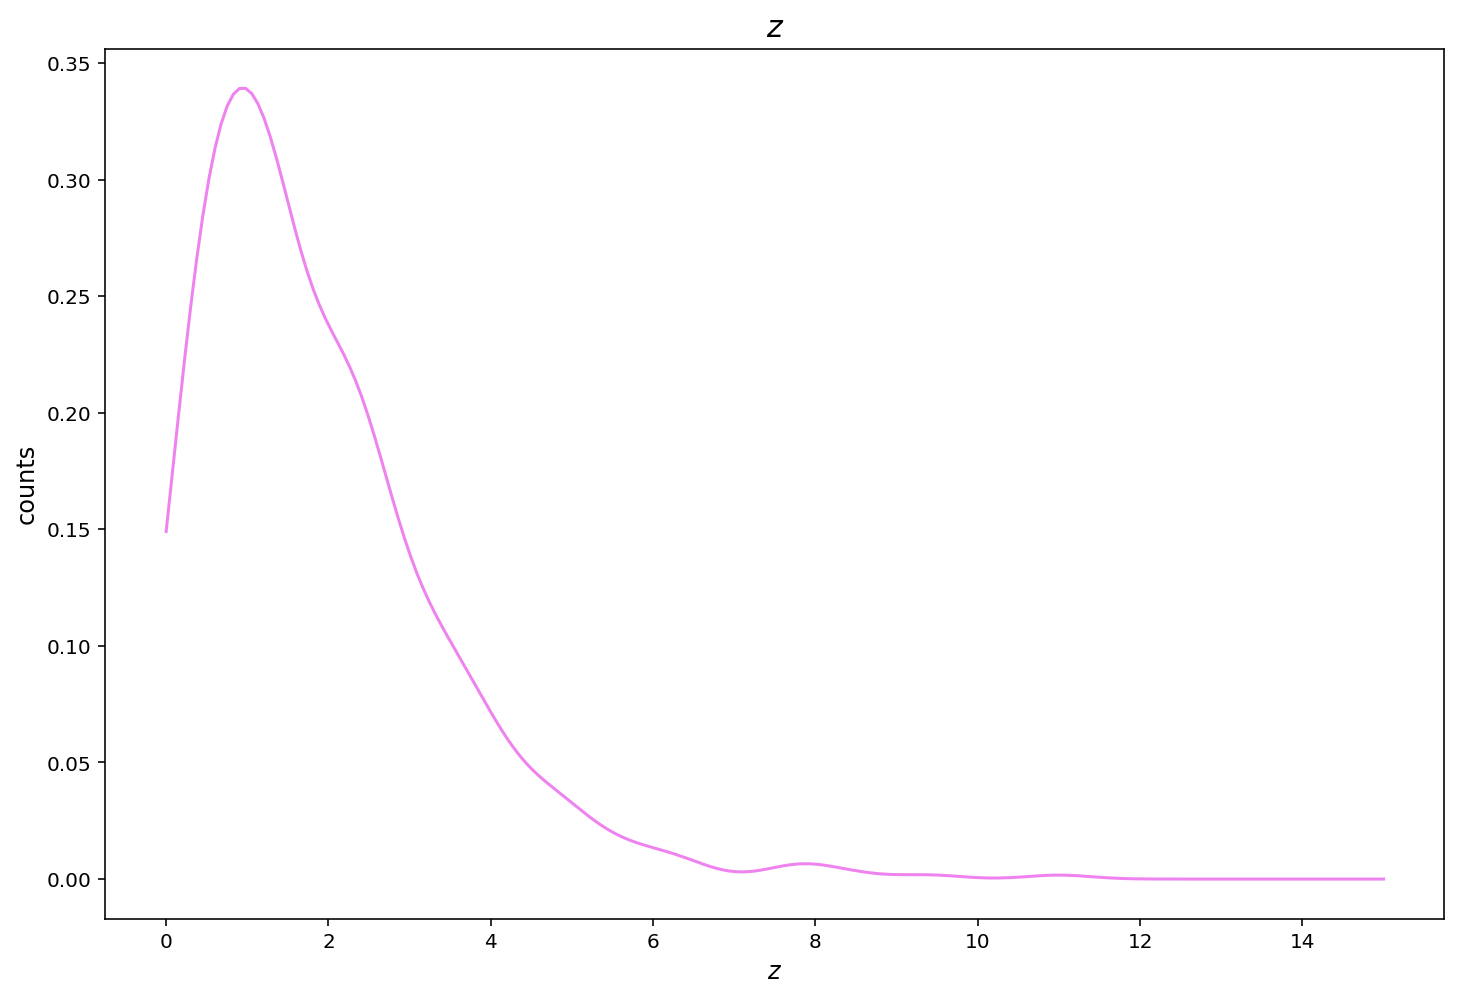

In [11]:
plt.figure(figsize=(12,8))
xgrid =np.linspace(0, 15, 200)
pdf = kde_sklearn(z_corr, bandwidth=h_opt)
plt.plot(xgrid, pdf, c='violet')
plt.xlabel(r"$z$", fontsize=12)
plt.ylabel(r'counts', fontsize=12)
plt.title(r"$z$", fontsize=15);

Here we see how the distribution is peaked at $z \sim 1.8$ (by eye..). There still could be perhaps some smaller peaks we ignore the existence of at higher redshifts, and that we can try to investigate using the techniques we saw in today's lecture. 

### $\log{T_{90}}$ and $\log{f}$

In [12]:
bwrange = np.linspace(0.01, 0.5, 20) # Test 10 bandwidths from 0.1 to 1.0
print(bwrange)

K = 5 # Do 5-fold cross validation

X_f = np.log10(fluence_corr[:, None])
X_t = np.log10(T90_corr[:, None])

h_opt = []

for X in [X_f, X_t]:

    grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
    grid.fit(X) #Fit the histogram data 

    h_opt.append(grid.best_params_['bandwidth'])
    
print(h_opt)

[0.01       0.03578947 0.06157895 0.08736842 0.11315789 0.13894737
 0.16473684 0.19052632 0.21631579 0.24210526 0.26789474 0.29368421
 0.31947368 0.34526316 0.37105263 0.39684211 0.42263158 0.44842105
 0.47421053 0.5       ]
[0.29368421052631577, 0.1131578947368421]


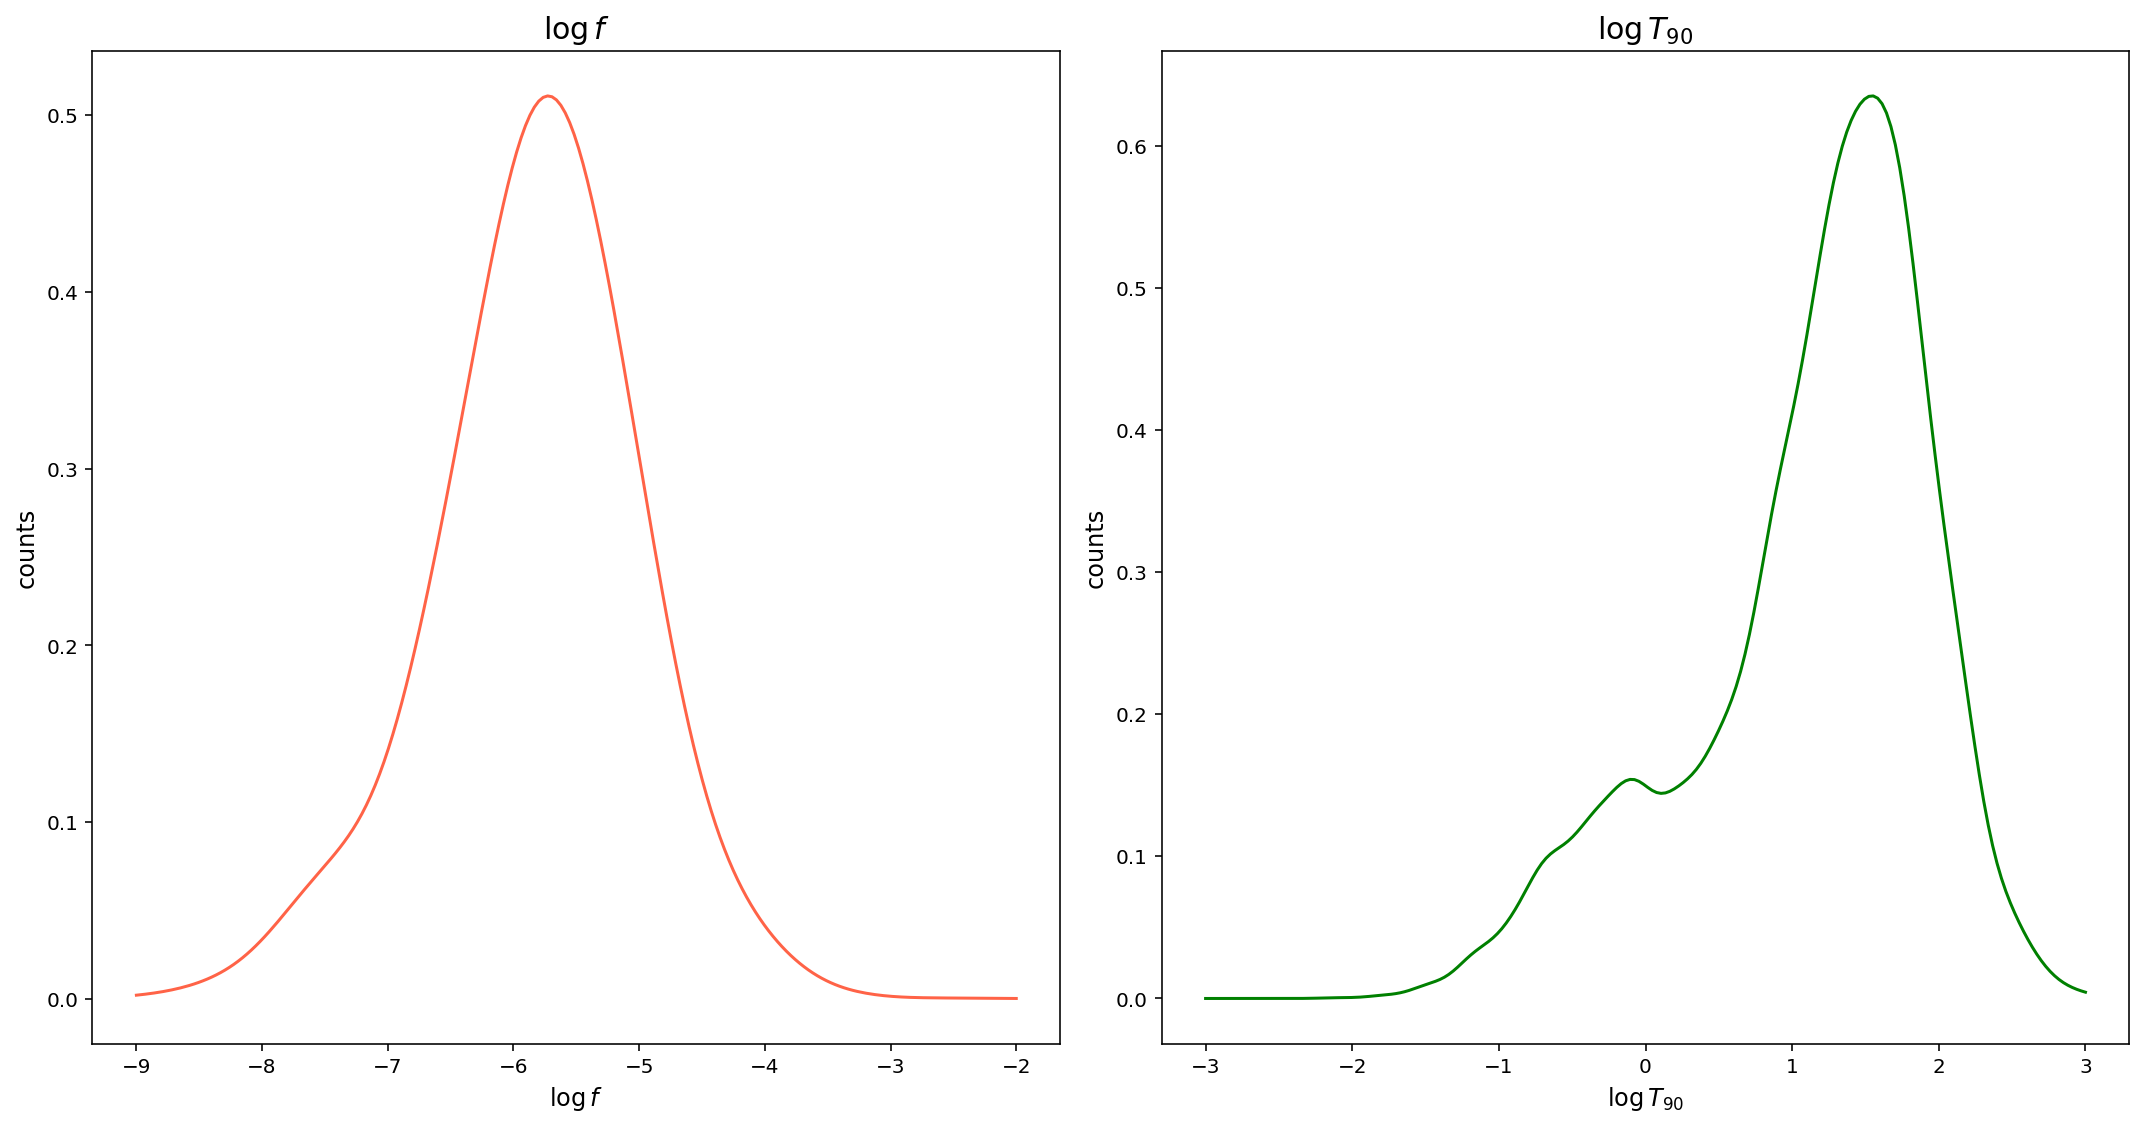

In [13]:
pdf = []

fig, ax = plt.subplots(1, 2, figsize=(15,8))

xgrid_f =np.linspace(-9, -2, 200)
xgrid_t =np.linspace(-3, 3, 200)

for xgrid, i, x in zip([xgrid_f, xgrid_t], [0, 1], [np.log10(fluence_corr), np.log10(T90_corr)]): 

    pdf.append(kde_sklearn(x, bandwidth=h_opt[i]))

ax[0].plot(xgrid_f, pdf[0], c='tomato')
ax[1].plot(xgrid_t, pdf[1], c='green')

ax[0].set_xlabel(r"$\log{f}$", fontsize=12)
ax[0].set_ylabel(r'counts', fontsize=12)
ax[0].set_title(r"$\log{f}$", fontsize=15)

ax[1].set_xlabel(r"$\log{T_{90}}$", fontsize=12)
ax[1].set_ylabel(r'counts', fontsize=12)
ax[1].set_title(r"$\log{T_{90}}$", fontsize=15)

fig.tight_layout();

I can see from this KDE plots that there seem to be one type of bursts in terms of the fluence, while there are perhaps two distinct populations of bursts in terms of the duration. I will try to inverstigate it using the clustering methods we saw in the lecture.  

## Clustering

The clustering techniques are useful to investigate whether there are different groups of data that have the same features. I will use them to first see if we can split the gamma ray bursts in some classes based on the different types of data we acquired. 

### $z$

I will try to first set $n_{cl} = 2$, just to see if something sensed comes out.

In [14]:
# analyze:
n_clusters = 2
#scaler = preprocessing.StandardScaler(), scaler.fit_transform
k_means = KMeans(n_clusters)
k_means.fit(X_z)

Y_z = k_means.predict(X_z)

I here report the KDE estimate I obtain via KMeans:

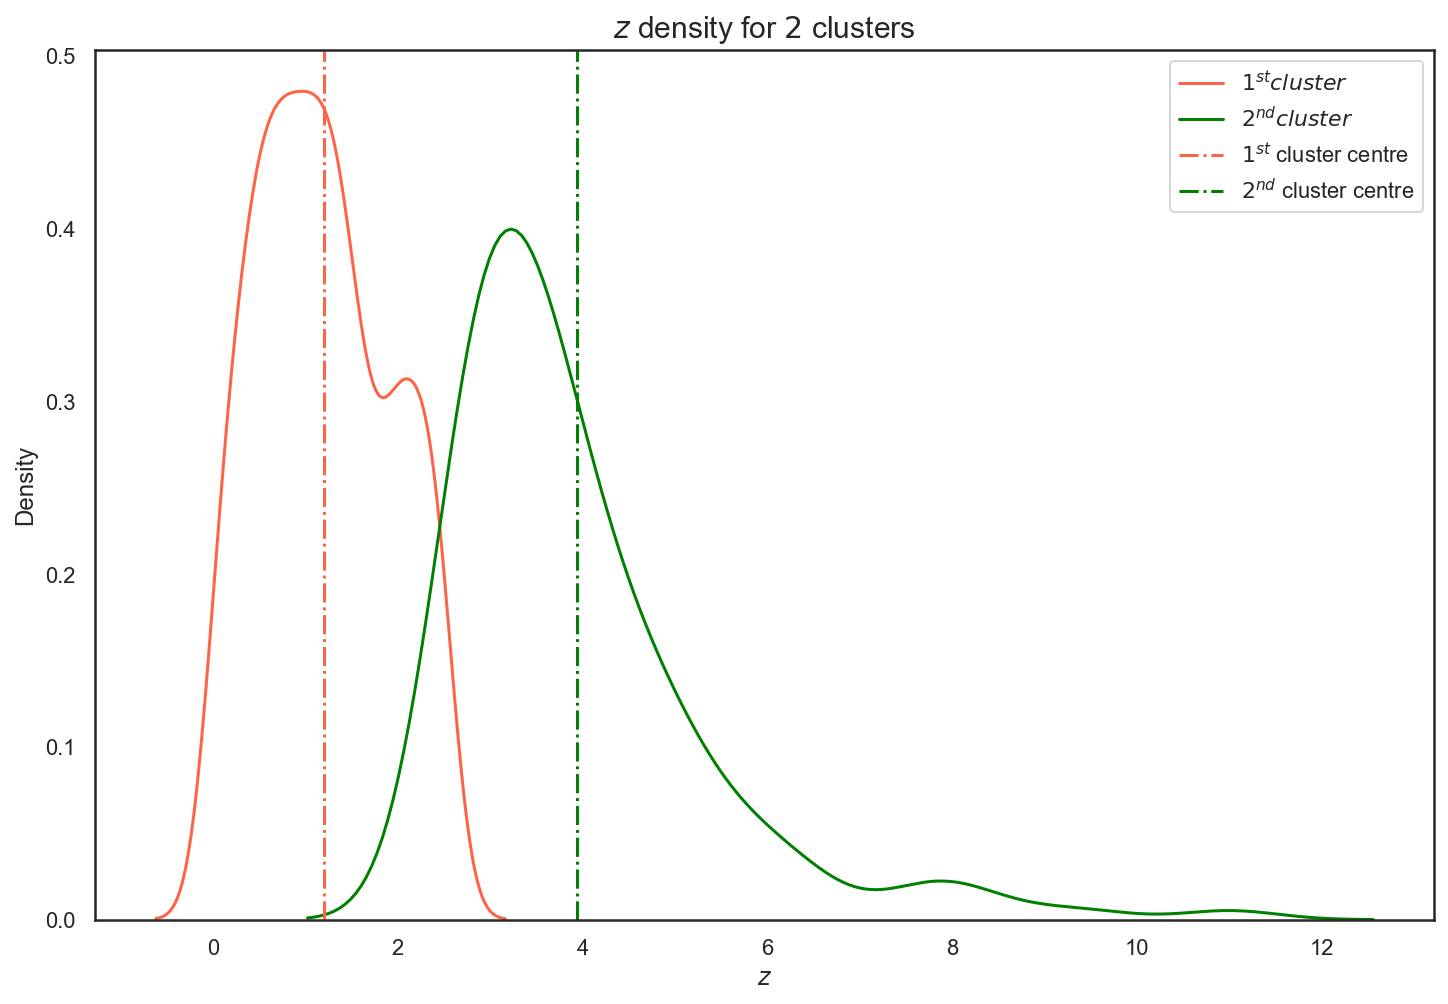

In [15]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

seaborn.kdeplot(z_corr[Y_z==0], c='tomato', label=r'$1^{st} cluster$')
seaborn.kdeplot(z_corr[Y_z==1], c='green', label=r'$2^{nd} cluster$')
plt.axvline(k_means.cluster_centers_[0], linestyle='-.', c='tomato', label='$1^{st}$ cluster centre')
plt.axvline(k_means.cluster_centers_[1], linestyle='-.', c='green', label='$2^{nd}$ cluster centre')
plt.xlabel(r"$z$")
plt.title("$z$ density for $2$ clusters", fontsize=15)

plt.legend();

Now I want to see if my first guess can be seen as the optimal choice for the clustering method. I will use the Meanshift algorithm.

In [16]:
#first estimate the optimal bandwidth
bandwidth = estimate_bandwidth(X_z) 

print("optimal bandwidth:", bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 

ms.fit(X_z)

Y_z_ms = ms.predict(X_z)

optimal bandwidth: 0.8675358714043994


Check the number of clusters it finds:

In [17]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 2
number of estimated singletons : 2
total number of estimated clusters : 4


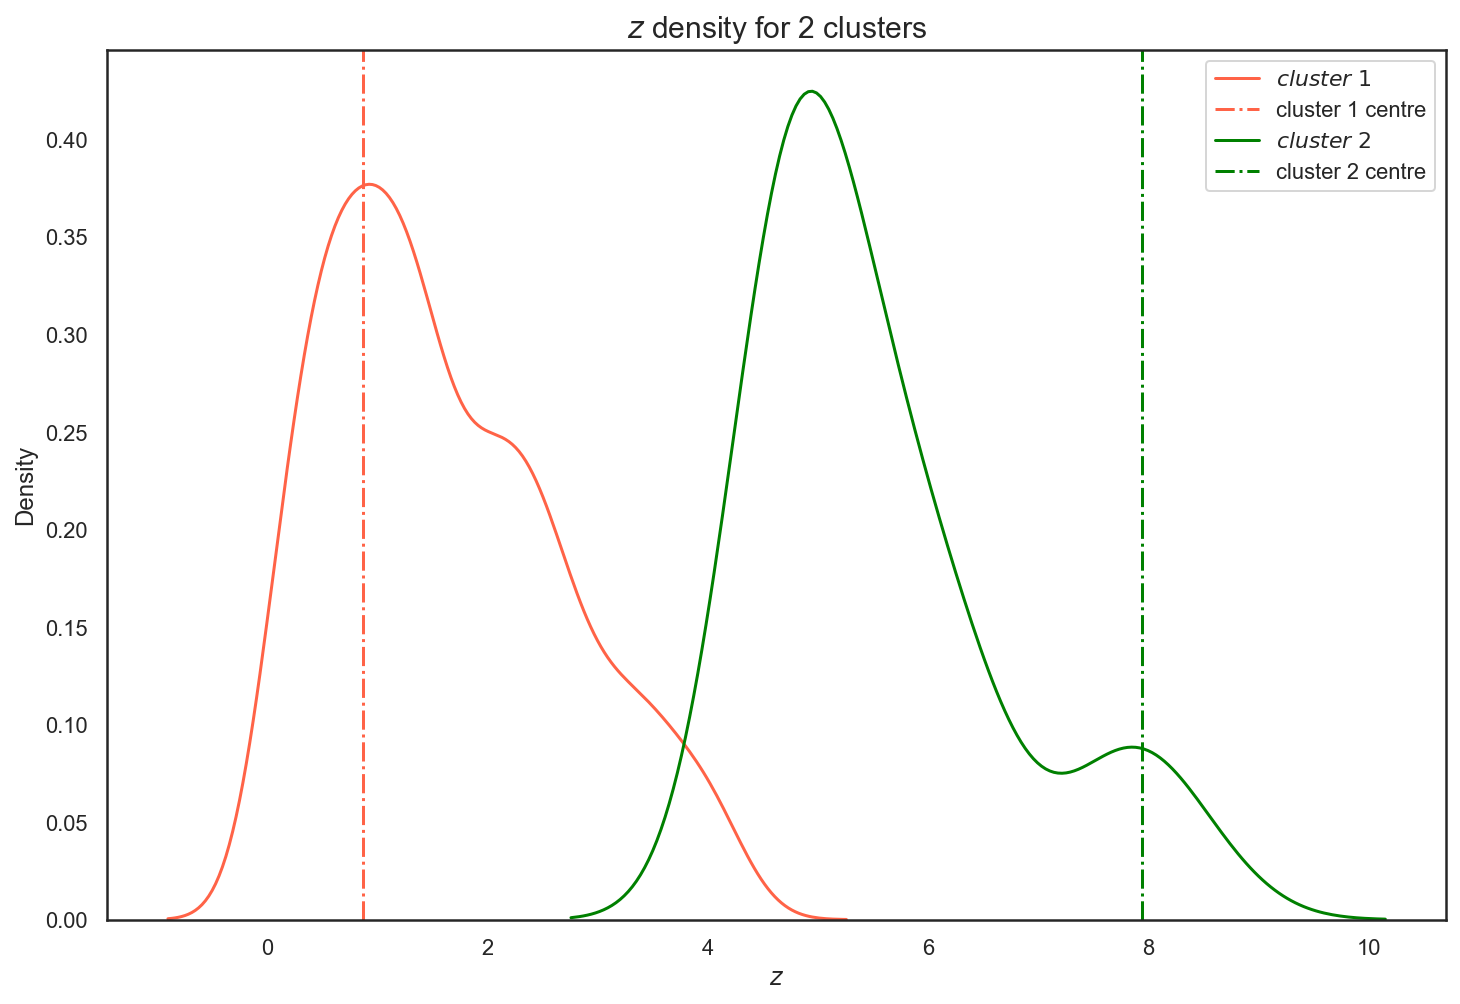

In [18]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

colors = ["tomato", "green"]

for i in range(0, n_clusters): 

    seaborn.kdeplot(z_corr[Y_z_ms==i], label=f'$cluster \ {i + 1}$', c=colors[i])
    plt.axvline(ms.cluster_centers_[i], linestyle='-.', c=colors[i], label=f'cluster {i+1} centre')

plt.xlabel(r"$z$")
plt.title(f"$z$ density for {n_clusters} clusters", fontsize=15)

plt.legend();

Apparently there are only two actual clusters, while two single points are set as centres of clusters with no other neighboring belonging elements (singleton). Furthermore, the cluster centers are similar only for the first of the two clusters, probably because the Meanshift algorithm strongly depends on the outliers that tend to move the centers towards these points. 

### $\log{T_{90}}$ and $\log{f}$

I will try to first set $n_{cl} = 2$, just to see if something sensed comes out.

In [19]:
# analyze:
n_clusters = 2
#scaler = preprocessing.StandardScaler(), scaler.fit_transform
k_means = KMeans(n_clusters)
k_means.fit(X_f)

Y_f = k_means.predict(X_f)

I here report the KDE estimate I obtain via KMeans:

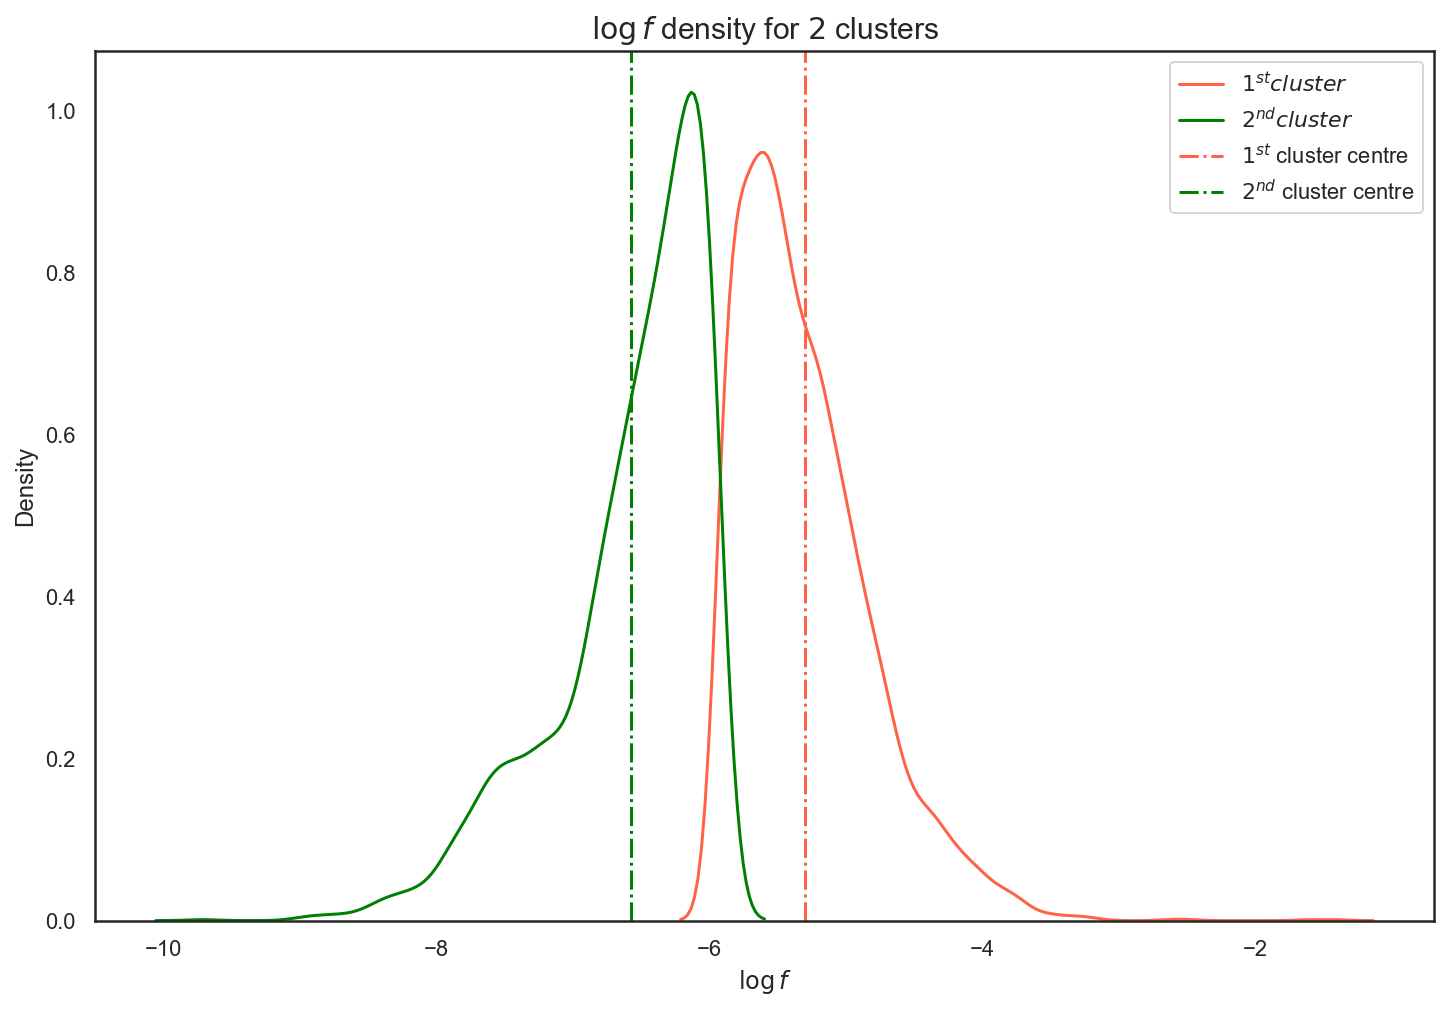

In [20]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

seaborn.kdeplot(np.log10(fluence_corr[Y_f==0]), c='tomato', label=r'$1^{st} cluster$')
seaborn.kdeplot(np.log10(fluence_corr[Y_f==1]), c='green', label=r'$2^{nd} cluster$')
plt.axvline(k_means.cluster_centers_[0], linestyle='-.', c='tomato', label='$1^{st}$ cluster centre')
plt.axvline(k_means.cluster_centers_[1], linestyle='-.', c='green', label='$2^{nd}$ cluster centre')
plt.xlabel(r"$\log{f}$")
plt.title("$\log{f}$ density for $2$ clusters", fontsize=15)

plt.legend();

In [21]:
# analyze:
n_clusters = 2
#scaler = preprocessing.StandardScaler(), scaler.fit_transform
k_means = KMeans(n_clusters)
k_means.fit(X_t)

Y_t = k_means.predict(X_t)

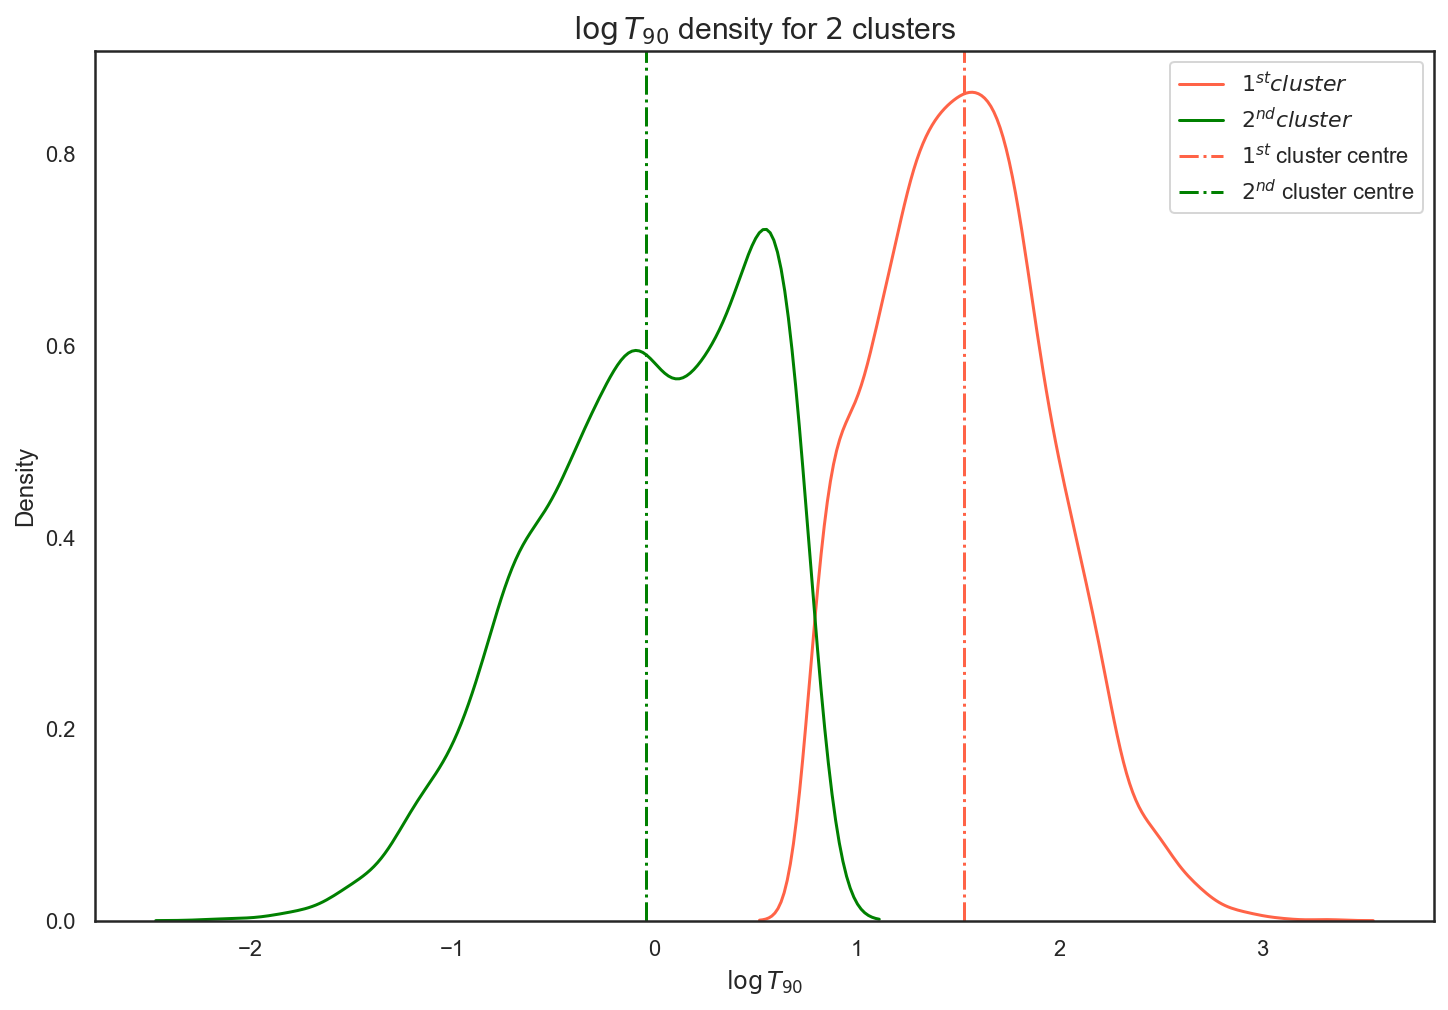

In [22]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

seaborn.kdeplot(np.log10(T90_corr[Y_t==0]), c='tomato', label=r'$1^{st} cluster$')
seaborn.kdeplot(np.log10(T90_corr[Y_t==1]), c='green', label=r'$2^{nd} cluster$')
plt.axvline(k_means.cluster_centers_[0], linestyle='-.', c='tomato', label='$1^{st}$ cluster centre')
plt.axvline(k_means.cluster_centers_[1], linestyle='-.', c='green', label='$2^{nd}$ cluster centre')
plt.xlabel(r"$\log{T_{90}}$")
plt.title("$\log{T_{90}}$ density for $2$ clusters", fontsize=15)

plt.legend();

Now I want to see if my first guess can be seen as the optimal choice for the clustering method. I will use the Meanshift algorithm.

In [23]:
#first estimate the optimal bandwidth
bandwidth = estimate_bandwidth(X_f, quantile=0.2) 

print("optimal bandwidth:", bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 

ms.fit(X_f)

Y_f_ms = ms.predict(X_f)

optimal bandwidth: 0.37384807676148335


Check the number of clusters it finds:

In [24]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 3
number of estimated singletons : 1
total number of estimated clusters : 4


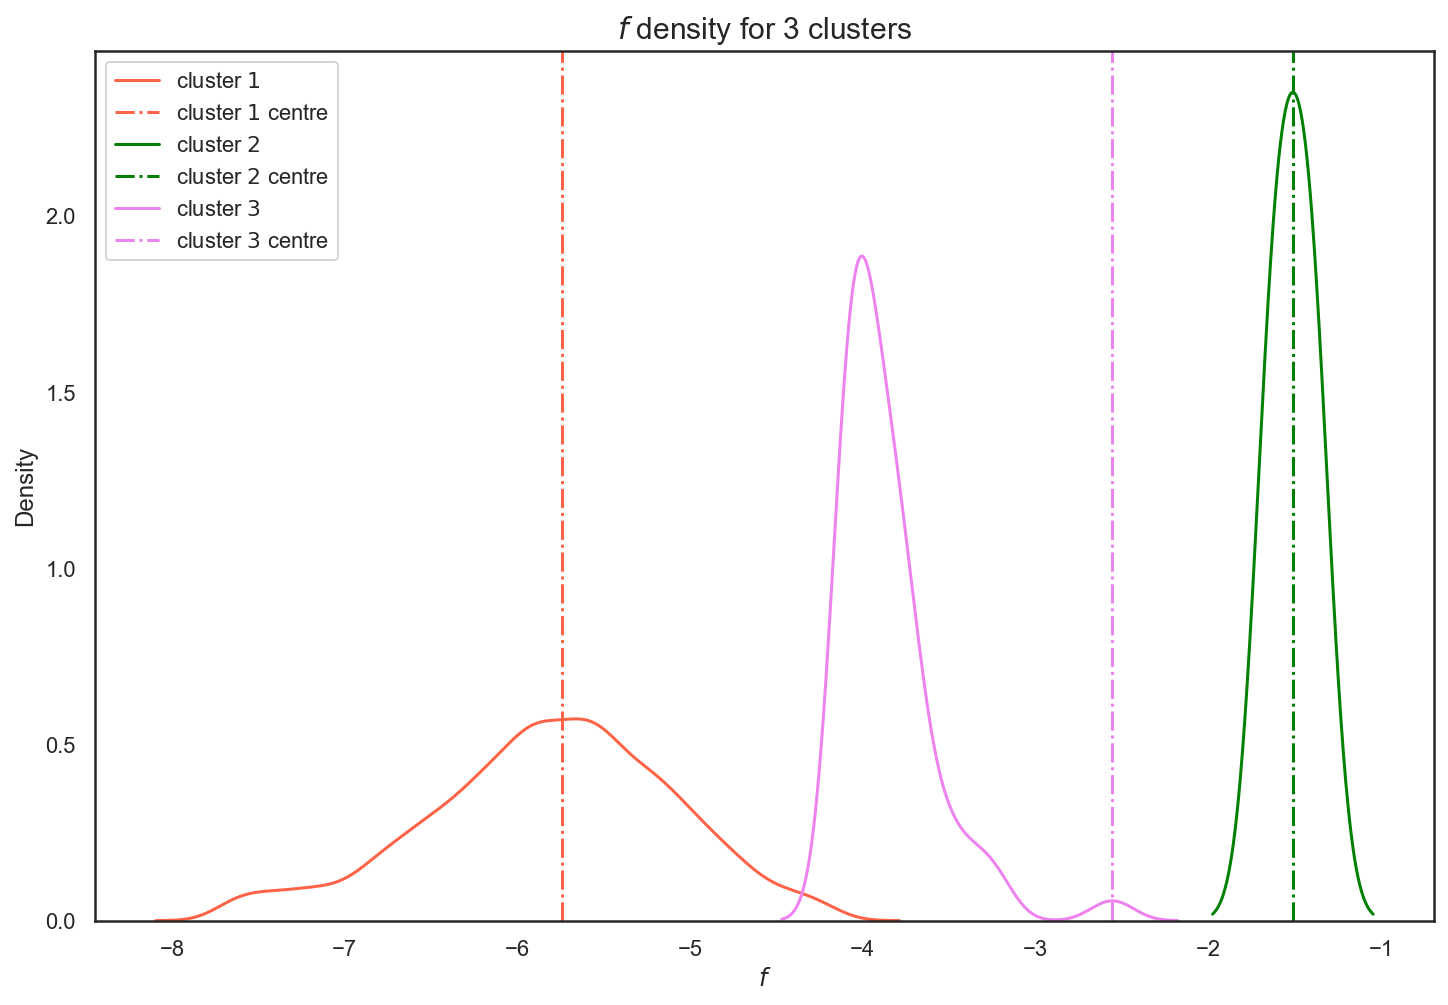

In [25]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

colors = ["tomato", "green", "violet"]

for i in range(0, n_clusters): 

    seaborn.kdeplot(np.log10(fluence_corr[Y_f_ms==i]), label=f'cluster ${i + 1}$', c=colors[i])
    plt.axvline(ms.cluster_centers_[i], linestyle='-.', c=colors[i], label=f'cluster ${i+1}$ centre')

plt.xlabel(r"$f$")
plt.title(f"$f$ density for {n_clusters} clusters", fontsize=15)

plt.legend();

From this results I personally think that a one-mode works fine for the $f$ values distribution. Let's see if anything changes with the $T_{90}$ value: 

In [26]:
#first estimate the optimal bandwidth
bandwidth = estimate_bandwidth(X_t, quantile=0.2) 

print("optimal bandwidth:", bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 

ms.fit(X_t)

Y_t_ms = ms.predict(X_t)

optimal bandwidth: 0.3687516991657019


In [27]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 2
number of estimated singletons : 0
total number of estimated clusters : 2


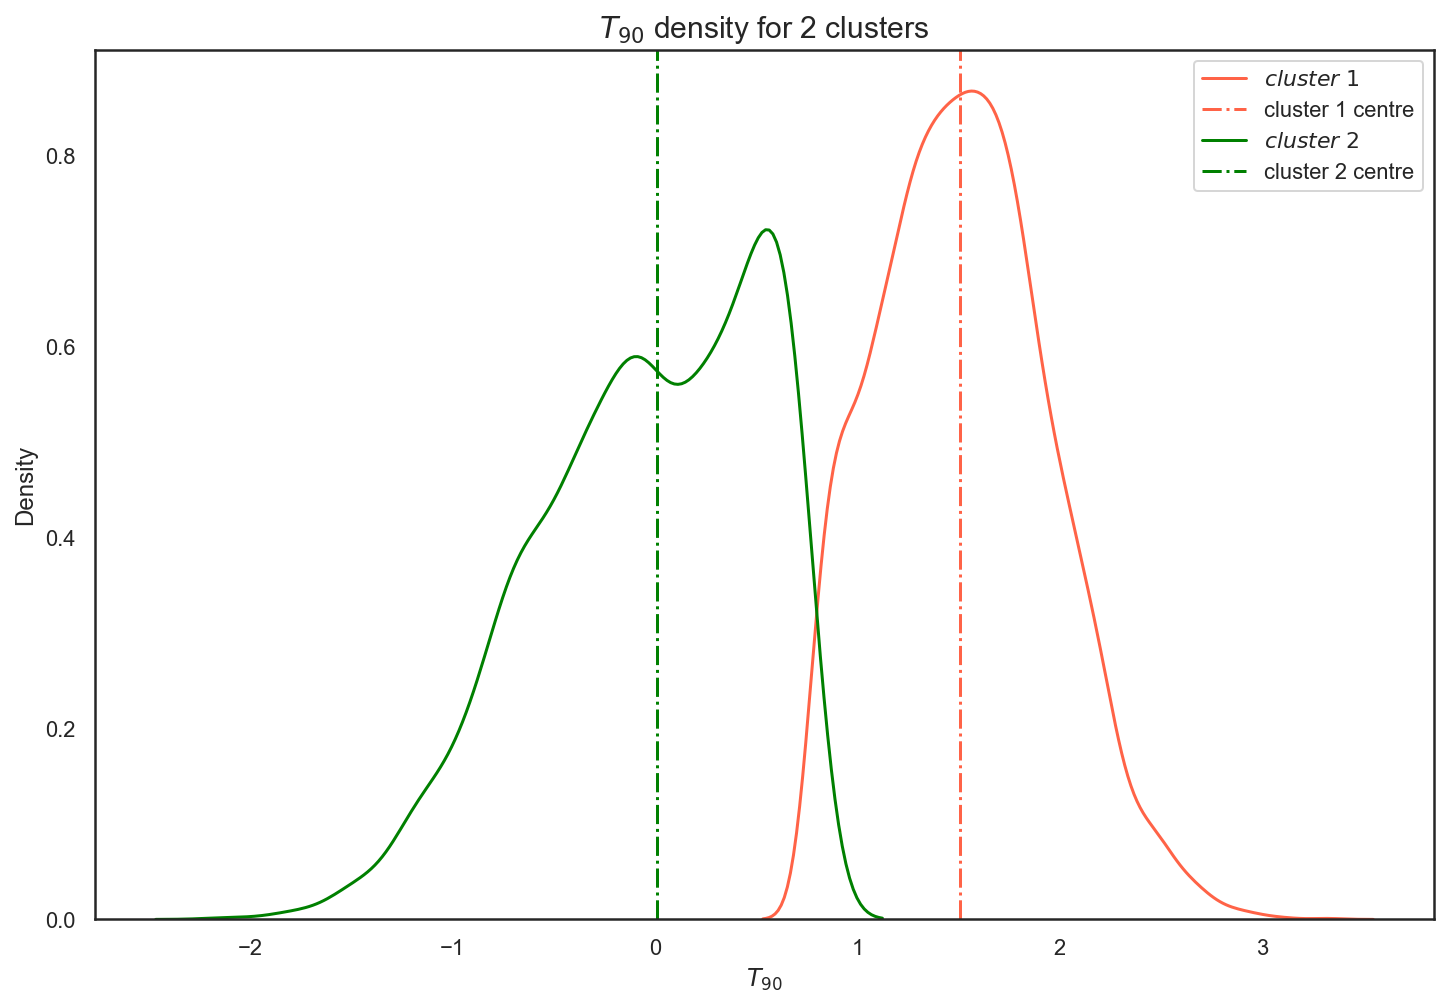

In [28]:
seaborn.set(rc={'figure.figsize':(12,8)})
seaborn.set_style("white")

for i in range(0, n_clusters): 

    seaborn.kdeplot(np.log10(T90_corr[Y_t_ms==i]), label=f'$cluster \ {i + 1}$', c=colors[i])
    plt.axvline(ms.cluster_centers_[i], linestyle='-.', c=colors[i], label=f'cluster {i+1} centre')

plt.xlabel(r"$T_{90}$")
plt.title(f"$T_{{90}}$ density for {n_clusters} clusters", fontsize=15)

plt.legend();

From this initial analysis I learned two main things: 
    
- 1) The variable that shows the multi-modality more evidently is the $T_{90}$ one, while I felt that in a way I was forcing the others I analyzed to have more centers while in reality they could be well described by using just one mode;

- 2) The two clustering methods I used were similar in case there were not strong outliers in data (meaning some points that had values extremely larger or smaller than the average); in the opposite case some more clusters were estimated, and some of them were just composed of singletons;

# 2-D distributions

In this section I am interested to study whether there can be two distinguished populations in $f$ based on the $T_{90}$ values:

In [29]:
# create mask for non-physical values

mask = np.logical_and(T90_s>0, fluence_s>0)
fluence_corr = fluence_s[mask]
T90_corr = T90_s[mask]

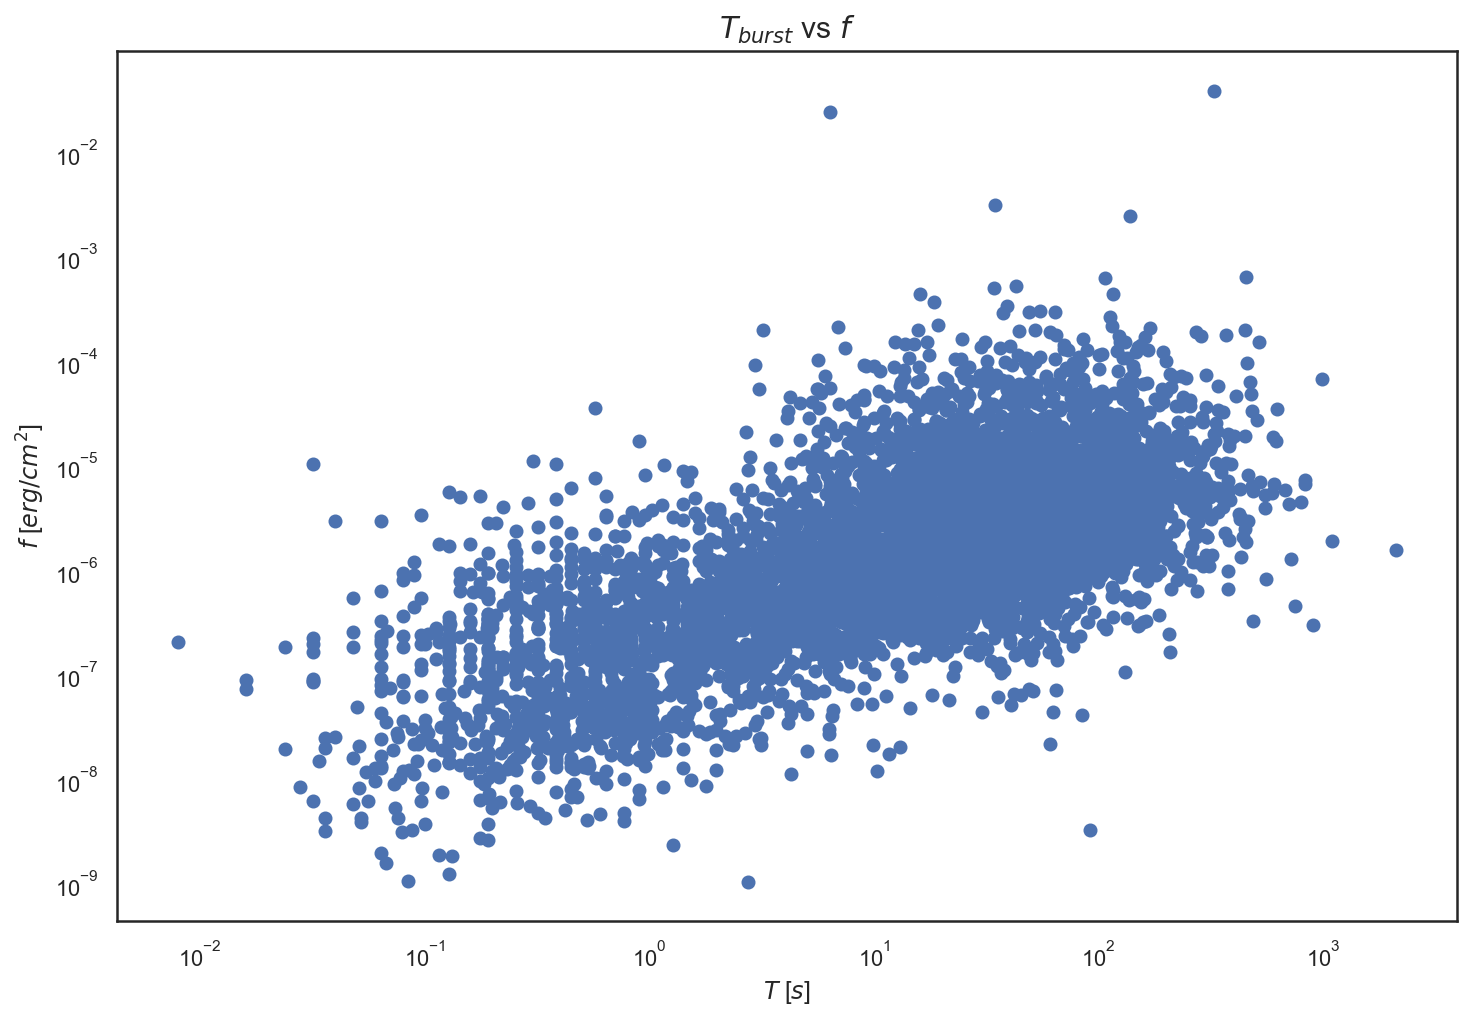

In [30]:
#plt.figure(figsize=(10,8))
plt.loglog(T90_corr, fluence_corr, 'o')
plt.xlabel(r"$T$ [$s$]", fontsize=12)
plt.ylabel("$f$ [$erg/cm^2$]", fontsize=12)
plt.title(r'$T_{burst}$ vs $f$', fontsize=15); 

To prepare for the analysis I regroup the valid data into a matrix:

In [31]:
matrix_val = np.array((np.log10(T90_corr), np.log10(fluence_corr)))
f_vs_t90 = matrix_val.transpose()

## Clustering

I first try with the KMeans method: by eye I would initially say we see two groups of bursts, depending on the value of $T_{90}$.  

In [44]:
# analyze:
n_clusters = 2
#scaler = preprocessing.StandardScaler(), scaler.fit_transform
k_means = KMeans(n_clusters)

k_means.fit(f_vs_t90)

KMeans(n_clusters=2)

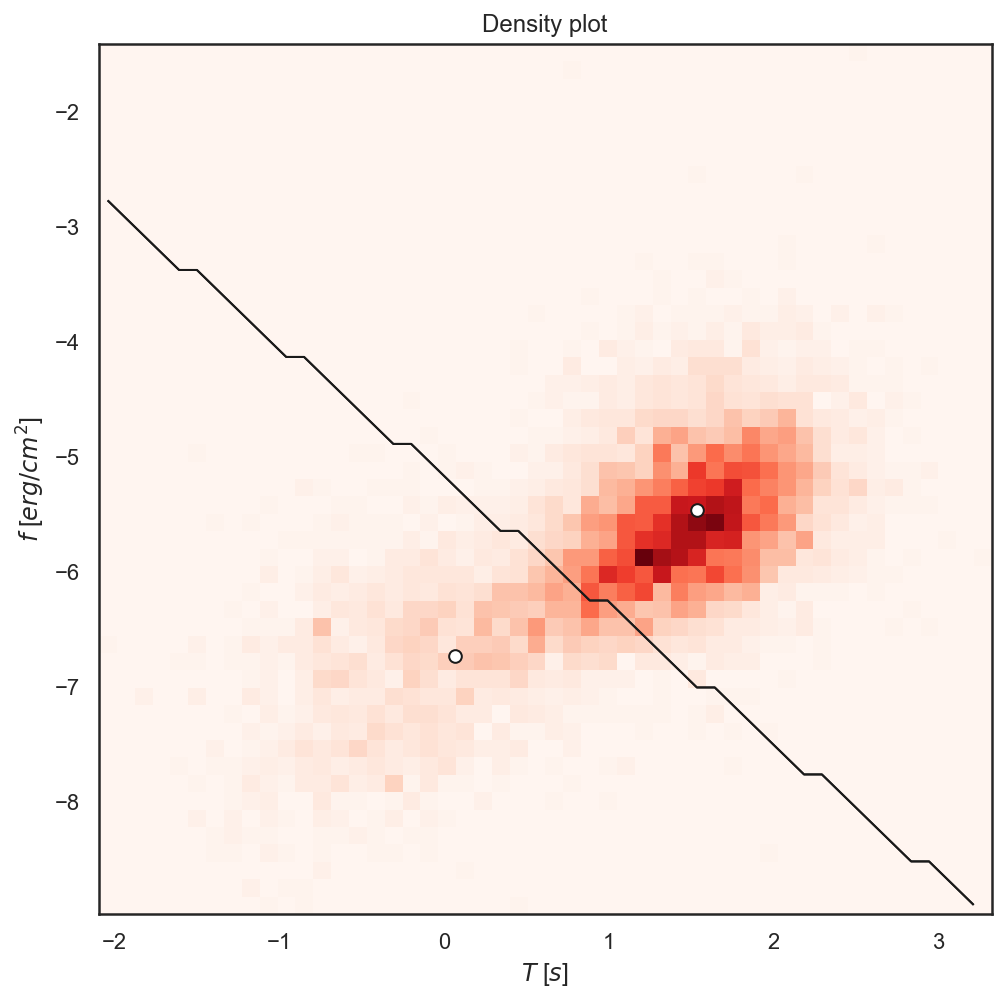

In [45]:
# Make some plots
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_t90[:,0], f_vs_t90[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Reds')

# plot cluster centers
cluster_centers = k_means.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = k_means.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = k_means.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$T$ [$s$]")
ax.set_ylabel("$f$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

It seems to properly identify the two centers. Let's see if the Meanshift algorithm works out the same solution or not: 

In [46]:
bandwidth = estimate_bandwidth(f_vs_t90) 

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False) 

ms.fit((f_vs_t90))

MeanShift(bandwidth=0.9189069584374705, bin_seeding=True, cluster_all=False)

In [47]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 2
number of estimated singletons : 1
total number of estimated clusters : 3


In [48]:
# to make the plot
counts_tot = np.array([ms.labels_.tolist().count(u) for u in labels_unique])

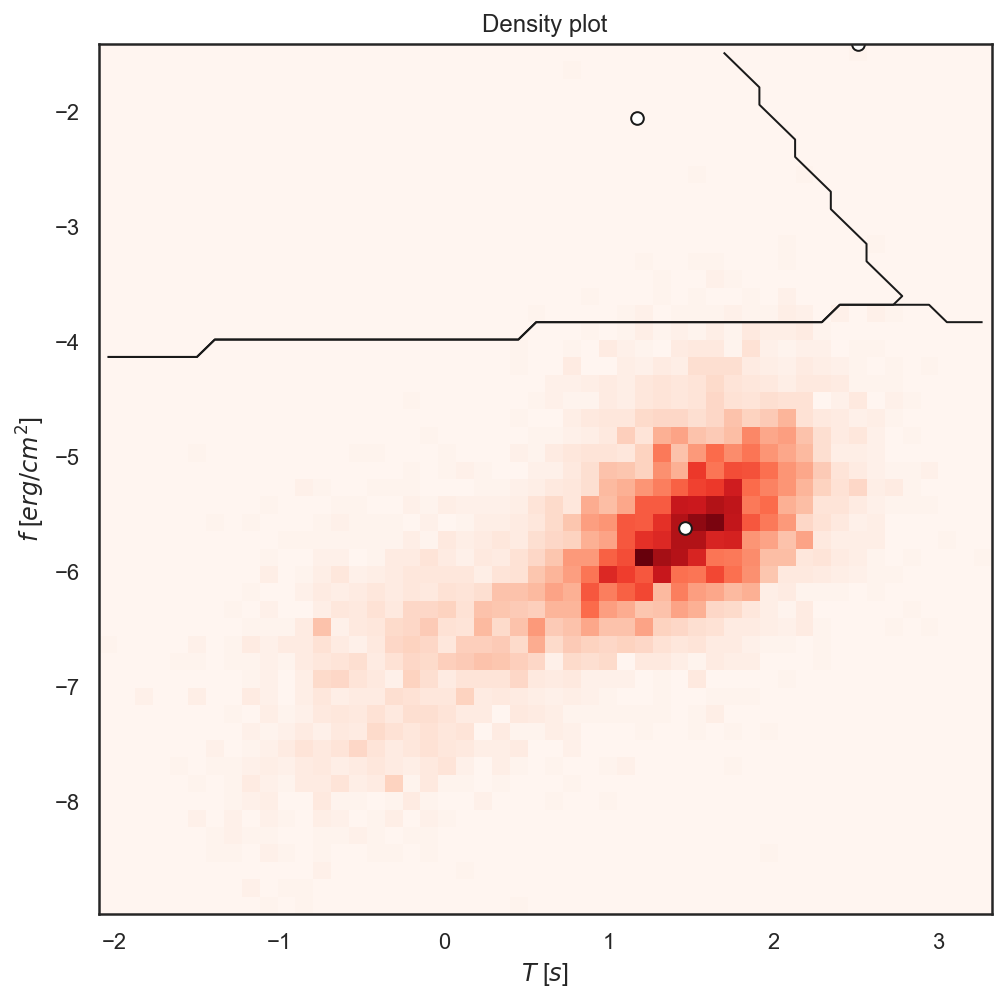

In [49]:
# Make some plots
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_t90[:, 0], f_vs_t90[:, 1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Reds')

# plot cluster centers
cluster_centers = ms.cluster_centers_
for i in range(0, len(ms.cluster_centers_)): 
    
    if counts_tot[i]==1: 

        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='r', edgecolors='k')
    else: 
        
        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$T$ [$s$]")
ax.set_ylabel("$f$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

Here, we see how the behaviour is different. Apparently, the algorithm isn't capable of finding the centers correctly. I can say it because it identifies cluster centers where the outliers are. I will try to change the following parameters to see if anything improves: 

- $\textit{bandwidth}$; 
- $\texttt{cluster_all}$ option;

In [50]:
bandwidth = estimate_bandwidth(f_vs_t90) 

ms = MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False) 

ms.fit((f_vs_t90))

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False)

In [51]:
labels_unique = np.unique(ms.labels_)
counts = np.array([ms.labels_.tolist().count(u) for u in labels_unique[labels_unique >= 0]])

n_clusters = len(labels_unique[labels_unique >= 0]) - len(counts[counts==1])
singletons = len(counts[counts==1])

print("number of estimated clusters with more than one element:", n_clusters)
print("number of estimated singletons :", singletons)
print("total number of estimated clusters :", singletons + n_clusters)

number of estimated clusters with more than one element: 6
number of estimated singletons : 6
total number of estimated clusters : 12


In [52]:
# to make the plot
counts_tot = np.array([ms.labels_.tolist().count(u) for u in labels_unique])

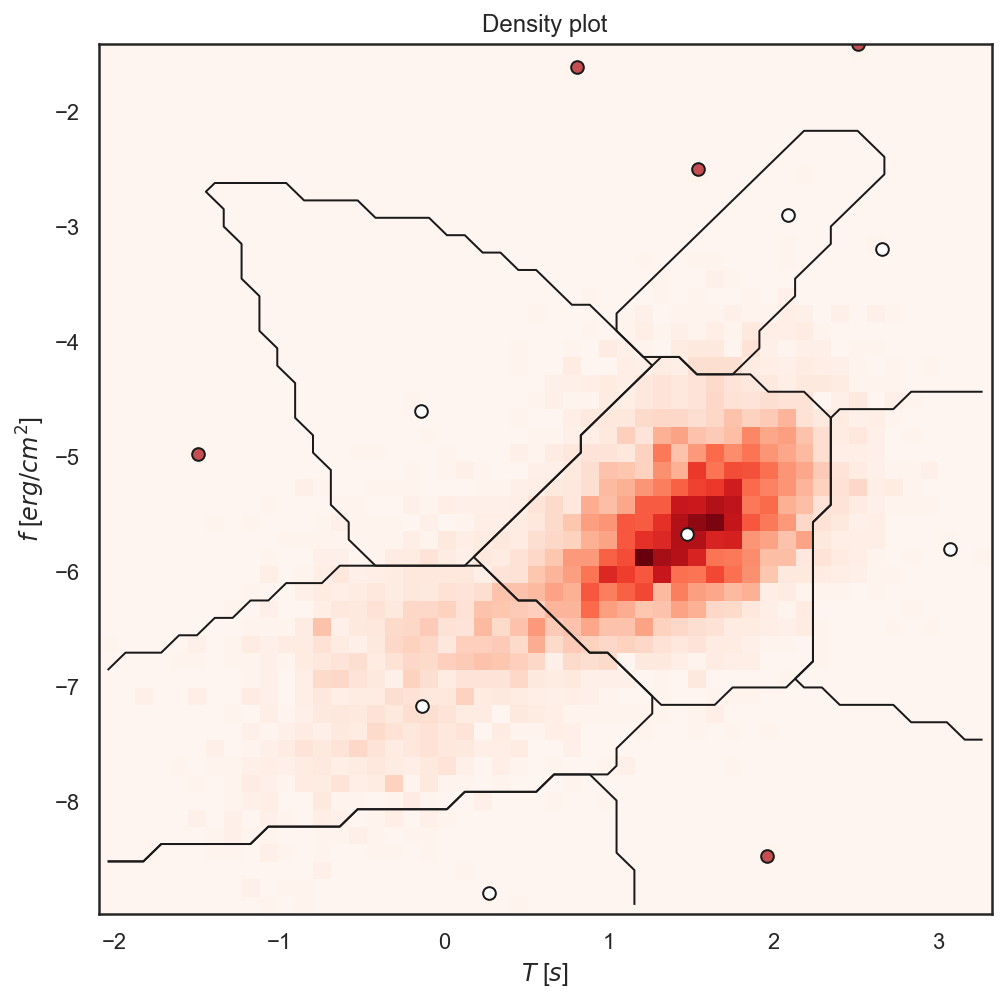

In [53]:
# Make some plots
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(f_vs_t90[:, 0], f_vs_t90[:, 1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Reds')

# plot cluster centers
cluster_centers = ms.cluster_centers_

for i in range(0, len(ms.cluster_centers_)): 
    
    if counts_tot[i]==1: 

        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='r', edgecolors='k')
    else: 
        
        ax.scatter(cluster_centers[i, 0], cluster_centers[i, 1],
               s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict((Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict((Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel(r"$T$ [$s$]")
ax.set_ylabel("$f$ [$erg/cm^2$]")

ax.set_title("Density plot")

plt.show()

The red centroids are the singletons. I hoped to see that mostly the algorithm was able to find two "real" centroids and the others were just resulting from the outliers effect on the gradient. It proved that the algorithm fails in this case to find a suitable number of clusters, returning at least $6$ viable instead of $2$ or $3$. 

Changing the $\textit{bandwidth}$ helped to get the two expected centroids in about the same position as the KMeans method, but also added up new centroids to the clustering results. Changing the $\texttt{cluster_all}$ option just reduced the amount of singletons, but didn't change anything in the outcome of the algorithm. 

The last clustering method I will try is the 2-D Gaussian Mixture, with two components. I will then compare the two outcomes and draw the conclusions: 

In [92]:
ggm = mixture.GaussianMixture(n_components=2, random_state=0)

ggm.fit(f_vs_t90)

c = mixture.GaussianMixture(n_components=2, random_state=0).fit_predict(f_vs_t90)

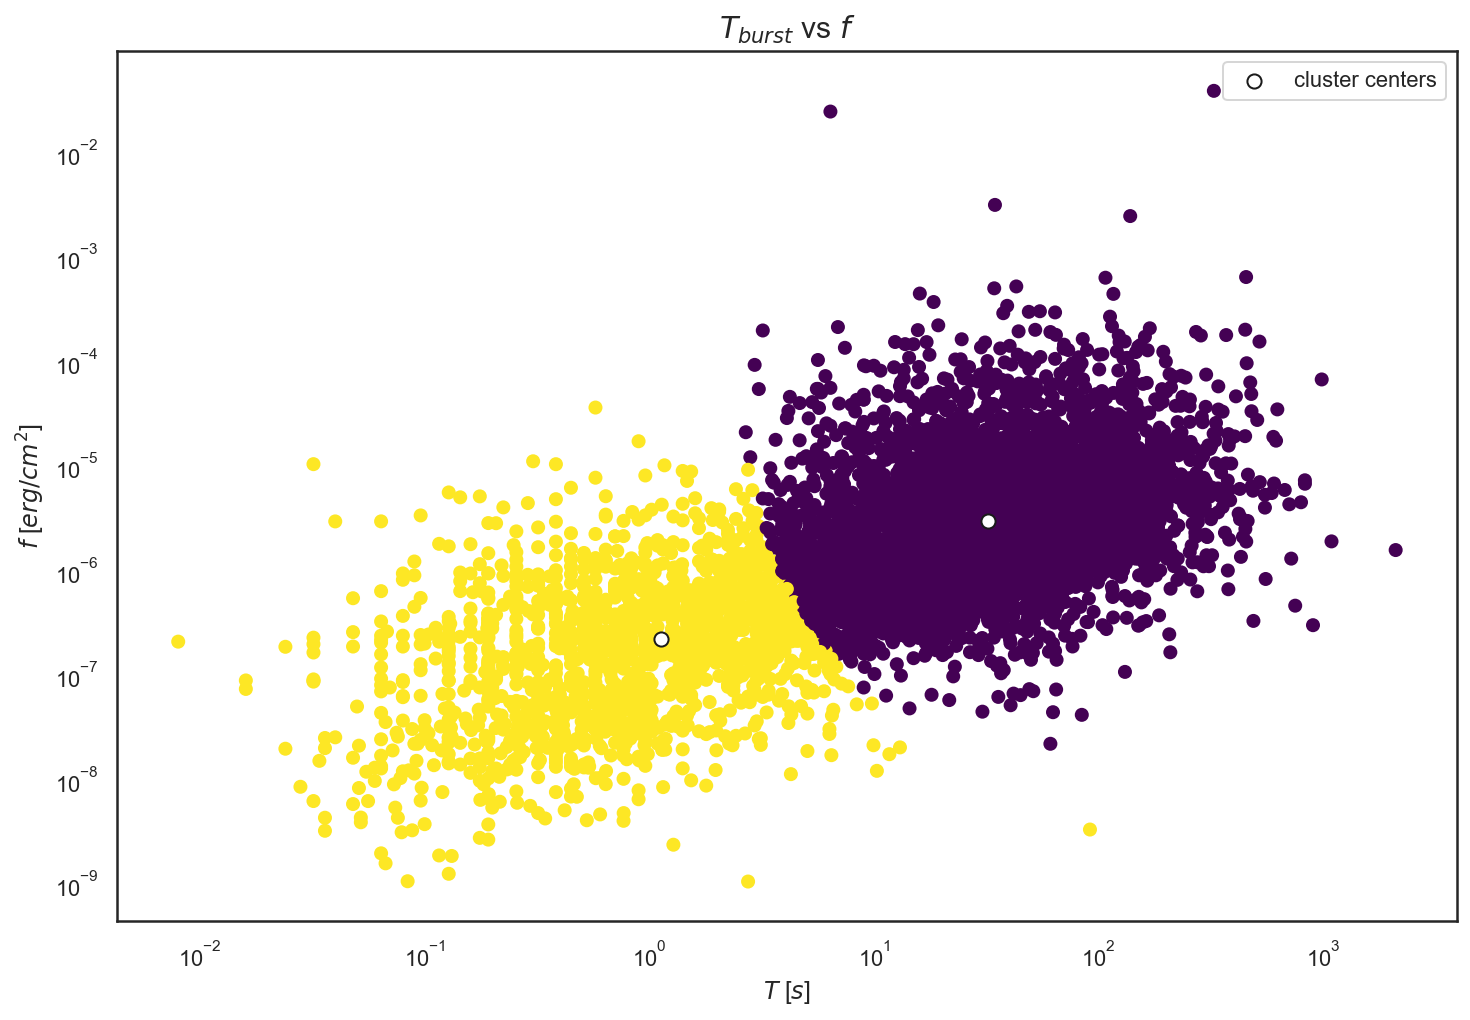

In [96]:
plt.scatter(T90_corr, fluence_corr, c=c, cmap='viridis')
plt.scatter(10**ggm.means_[0, 0], 10**ggm.means_[0, 1], c='w', edgecolors='k', s=50, label='cluster centers')
plt.scatter(10**ggm.means_[1, 0], 10**ggm.means_[1, 1], c='w', edgecolors='k', s=50)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$T$ [$s$]", fontsize=12)
plt.ylabel("$f$ [$erg/cm^2$]", fontsize=12)
plt.title(r'$T_{burst}$ vs $f$', fontsize=15)
plt.legend();

Up until now, this is what I found. 

$\textbf{Physics related}$: there are two semi-distinct populations of bursts, depending on the duration only. Apparently, the other distributions appear to be one-modal and should accout for all possible cases. 

$\textbf{Algorithms related}$: among the many algorithms I used, the Meanshift proved to be the most problematic when it came to outliers in data. In fact it would subatantially fail to identify the clusters correctly, leading us to believe that there are many more. It is probably due to its structure, where very far points would inevitably weigh in the gradient calculation. 

In [97]:
#maybe check with the errors?